In [10]:
import torch.nn as nn
import os
import torch.nn.functional as F
from collections import Counter
from torchvision import transforms, datasets
import torchvision
import torchmetrics
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
import torch
import matplotlib.pyplot as plt
import torchinfo
import numpy as np
import logging
import pandas as pd
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
from helper import set_device, set_deterministic, set_seed, build_dataloaders_fmnist, train_model


In [11]:
device = set_device()

PyTorch version: 2.2.2
Is MPS (Metal Performance Shader) built? True
Is MPS available? True
Using device: mps


In [12]:
transforms = transforms.Compose([
    transforms.Resize((256, 256)), 
    transforms.ToTensor()
])

In [13]:
set_seed(42)

Set seed for reproducibility: 42


In [14]:
BATCH_SIZE = 128
LEARNING_RATE = 0.001
NUM_EPOCHS = 5
GRAYSCALE = True, 
NUM_WORKERS = 10
NUM_FEATURES = 28*28


In [15]:
train_dataloader, test_dataloader,  test_dataset_2, class_names = build_dataloaders_fmnist(
    data_path= "../../data", 
    train_transforms=transforms,
    test_transforms =transforms, 
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    
)

In [16]:
len(train_dataloader), len(test_dataloader)

(469, 79)

In [17]:
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

torch.Size([128, 1, 256, 256]) torch.Size([128])


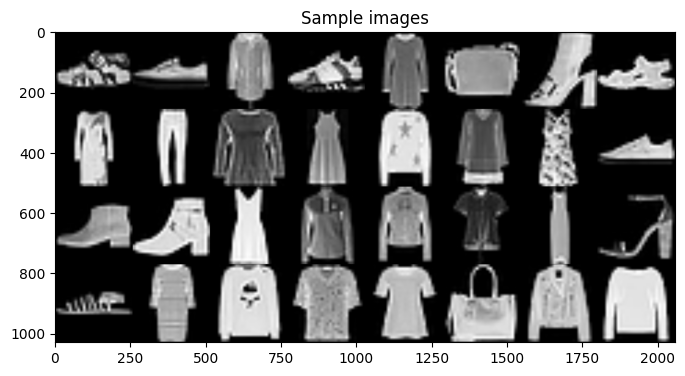

In [18]:
for image, label in train_dataloader:
    print(image.size(), label.size())
    break

plt.figure(figsize=(8, 8))
plt.title('Sample images')
plt.imshow(np.transpose(torchvision.utils.make_grid(image[:32], padding=1, normalize=True), (1, 2, 0)))
plt.show()

In [19]:
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out




class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes, grayscale):
        self.inplanes = 64
        if grayscale:
            in_dim = 1
        else:
            in_dim = 3
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(in_dim, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, (2. / n)**.5)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = x.view(x.size(0), -1)
        logits = self.fc(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas



def resnet18(num_classes):
    """Constructs a ResNet-18 model."""
    model = ResNet(block=BasicBlock, 
                   layers=[2, 2, 2, 2],
                   num_classes=len(class_names),
                   grayscale=GRAYSCALE)
    return model

In [20]:
model = resnet18(num_classes=len(class_names)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

In [21]:
torchinfo.summary(model, input_size=(BATCH_SIZE, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [128, 10]                 --
├─Conv2d: 1-1                            [128, 64, 14, 14]         3,136
├─BatchNorm2d: 1-2                       [128, 64, 14, 14]         128
├─ReLU: 1-3                              [128, 64, 14, 14]         --
├─MaxPool2d: 1-4                         [128, 64, 7, 7]           --
├─Sequential: 1-5                        [128, 64, 7, 7]           --
│    └─BasicBlock: 2-1                   [128, 64, 7, 7]           --
│    │    └─Conv2d: 3-1                  [128, 64, 7, 7]           36,864
│    │    └─BatchNorm2d: 3-2             [128, 64, 7, 7]           128
│    │    └─ReLU: 3-3                    [128, 64, 7, 7]           --
│    │    └─Conv2d: 3-4                  [128, 64, 7, 7]           36,864
│    │    └─BatchNorm2d: 3-5             [128, 64, 7, 7]           128
│    │    └─ReLU: 3-6                    [128, 64, 7, 7]           --
│

In [ ]:
pytorch_model, results = train_model(model = model, 
                                     criterion = criterion, 
                                     optimizer = optimizer, 
                                     train_dataloader= train_dataloader, 
                                     test_dataloader=  test_dataloader, 
                                     epochs = NUM_EPOCHS, 
                                     device = device)